# V471TAU

## Differential Rotation 

The parameters that will be used in each epoch are:

|           Parameter   | 2004       |  2005     |
|              :---:    | :---:      | :---:     |
|$K$ (km/s)             | $149.3$    | $149.3$   |  
|$v_\mathrm{rad}$ (km/s)| $34.6$     | $34.7$    |
|$\phi$                 | $-0.0027$  | $-0.0022$ | 
| $i$                   | $80$       | $80$      |
|$v\sin(i)$ (km/s)      | $90.0$     |  $90.0$   |
| EQW                   | $5.12$     | $5.12$    |



In [59]:
lev_o = (12.06,12.200)
lev_do = (0.00, 0.230)

### DATA IN 2004  

In [60]:
# load modules
import numpy as N
import matplotlib.pyplot as P
from scipy.optimize import leastsq
import cmocean as cm
import matplotlib.font_manager
P.style.use(['seaborn-white', 'seaborn-paper'])
matplotlib.rc("font", family="Times New Roman", size=20)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Define the number of sigmas that you want to consider 
nsigma=9.

# Read file with informations in each run
beta, gamma, chisq, s, sp_ph, test, cool, hot = N.genfromtxt('data/search_dr_i_2004.txt', unpack=True)

#Change to oeq and do
period =  0.5211833875 # in days
Omega0 = 2*N.pi/period
Oeq = (1 - beta)*Omega0
dO = gamma*Omega0

# Now we need to find the number of points to find the error bar
cycle, vr, snI, I, cycleV, vrV, snV, V = rstokes('data/v471tau_04.ss')
count=0
for i in range(len(cycle)):
    count += I[i].shape[0]
    
#Compute the corresponding variation in "reduced chisq"
dchisq = nsigma**2*2.3/count

# Set global min of spot coverage
vmin = sp_ph.min()
sp_ph /= vmin
print(vmin)

#Set levels for plotting
lev = [1. + isigma**2*(2.3/count) for isigma in range(int(nsigma)+1)]
cut_sigma = int(nsigma) + 2
lev_1 = [1. + isigma**2*(2.3/count) for isigma in range(1,cut_sigma,2)]

#select data within the conditions:
ic = N.bitwise_and(chisq <= 1.0005, test <= 0.005)
Oeq = Oeq[ic]; dO = dO[ic]; chisq = chisq[ic]; s = s[ic]; sp_ph = sp_ph[ic] 
test = test[ic]; cool = cool[ic]; hot = hot[ic]
#we also add another condition for the data (optional):
isp = N.bitwise_and(sp_ph >= 1.00*vmin, sp_ph <= (1. + cut_sigma**2*3.53/count))
Oeq = Oeq[isp]; dO = dO[isp]; chisq = chisq[isp]; s = s[isp]; sp_ph = sp_ph[isp] 
test = test[isp]; cool = cool[isp]; hot = hot[isp]

# Create a mesh and create new matrix with mesh's shape
x, y = N.meshgrid(N.unique(Oeq), N.unique(dO))
m_z = N.ones_like(x)*9999.
m_test = N.ones_like(x)*9999.

for i in range(sp_ph.shape[0]):
    indx = N.bitwise_and(x == Oeq[i], y == dO[i])
    m_z[indx] = sp_ph[i]
    m_test[indx] = test[i]

mask = m_z > (1. + cut_sigma**2*3.53/count)
z=N.ma.array(m_z, mask=mask)  
mask1 = m_test >= 1.
c_test=N.ma.array(m_test, mask=mask1)  

print(' Number of points in the fit: ', Oeq.shape[0])
print('\n The lowest spot in the data was at:')
print('Oeq = ', Oeq[sp_ph.argmin()], 'dO = ', dO[sp_ph.argmin()])

# find center in the 2d-plane
optimize_func = lambda x: x[0]*Oeq**2 + x[1]*Oeq + x[2]*dO**2 + x[3]*dO \
                            + x[4]*Oeq*dO + x[5] - sp_ph
coef = leastsq(optimize_func, [1.,1.,1.,1.,1.,1.])[0]
a, b, c, d, e, f = coef.copy()
best_x = 1./(4*a*c/e - e)*(d - 2.*c*b/e)
best_y = 1./(4*a*c/e - e)*(b - 2.*a*d/e)
dx = 1./N.sqrt(a - e**2/(4*c))
dy = 1./N.sqrt(c - e**2/(4*a))

dx /= N.sqrt(count)
dy /= N.sqrt(count)

w_min = a*best_x**2 + b*best_x + c*best_y**2 + d*best_y + e*best_x*best_y + f 
res = a*Oeq**2 + b*Oeq + c*dO**2 + d*dO + e*Oeq*dO + f - sp_ph


print('Position of the center on this plane:')
print(r'Omega_EQ = %.3f and dO = %.3f' %(best_x, best_y))
print('dOeq = %.3f and d(dO) = %1.3f' %(dx, dy))

print(r'beta = %.6f and gamma = %.6f' %(1.- best_x/Omega0, best_y/Omega0))


print('\n Min Spot from fit:')
print('Min Spot = ', w_min)
print('RMS = ', N.sqrt(N.mean(res**2)))
print('RMS x dchisq =', N.sqrt(N.mean(res**2))*(count/2.3)) #2params

0.1257043
 Number of points in the fit:  170

 The lowest spot in the data was at:
Oeq =  12.108500053899943 dO =  0.10899998252897637
Position of the center on this plane:
Omega_EQ = 12.105 and dO = 0.099
dOeq = 0.001 and d(dO) = 0.004
beta = -0.004118 and gamma = 0.008177

 Min Spot from fit:
Min Spot =  1.0004001751131
RMS =  0.0003786780052271985
RMS x dchisq = 4.576735299698115


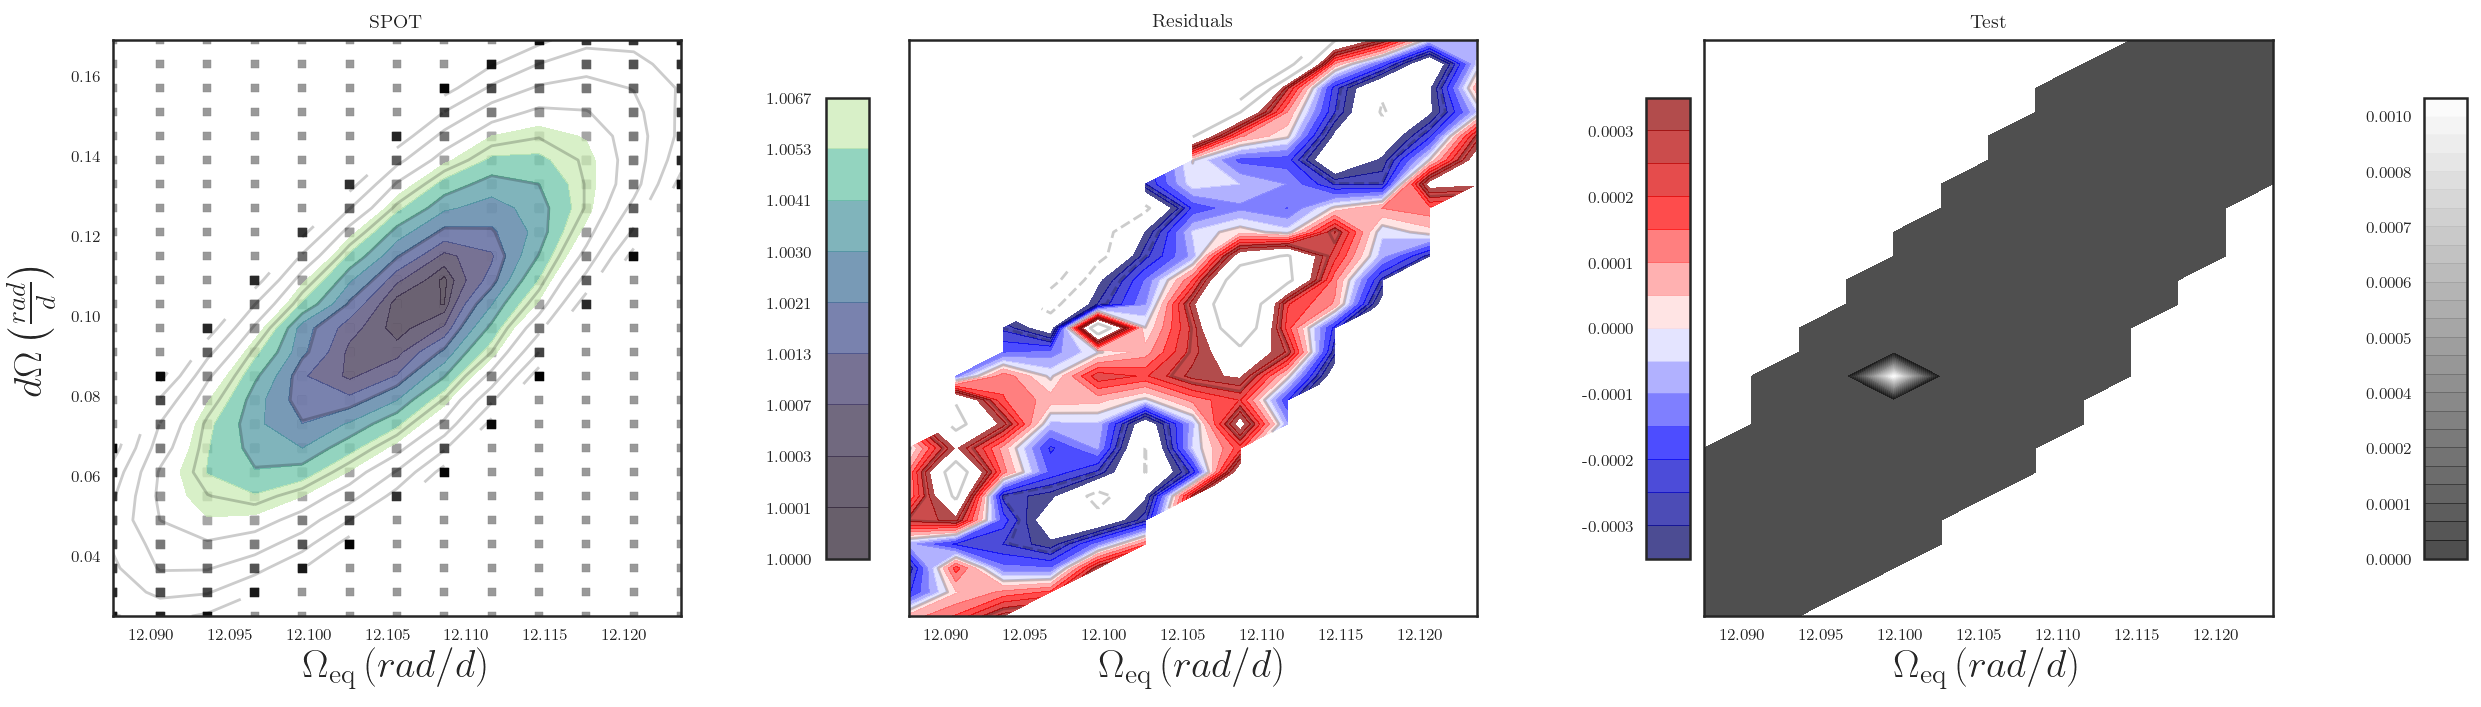

In [61]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
cmap = cmocean.cm.deep_r 

fig, ax = P.subplots(1,3, figsize=(15,4), sharey=True)
ax[0].scatter(x, y, marker = 's', s=20, color='gray', alpha=0.8)
ax[0].scatter(x, y, c=z, marker = 's', s=20, alpha=1.)
ax[0].set_title('SPOT')
im = ax[0].contourf(x, y, z, levels=lev, cmap=cmap, alpha=0.7)
ax[0].contour(x, y, z, colors='k', alpha=0.2)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax = fig.add_axes([0.33, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im, cax = cax, ticklocation = 'left', format = '%.4f')
cbar.ax.set_xticklabels([r'%d \sigma' %i for i in range(0,int(nsigma)+1)])
ax[0].set_xlim((x.min(), x.max()))
ax[0].set_ylim((y.min(), y.max()))
ax[0].plot(best_x, best_y, 'x', color='k')
ax[0].set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$', fontsize=20)
ax[0].set_ylabel(r'$d\Omega \left(\frac{rad}{d}\right)$', fontsize=20)

# Residual
res = a*x**2 + b*x + c*y**2 + d*y + e*x*y + f - z
ax[1].set_title('Residuals')
im1 = ax[1].contourf(x, y, res, levels=N.linspace(-1,1,15)*4.e-4, cmap='seismic', alpha=0.7)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax1 = fig.add_axes([0.71, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im1, cax = cax1, ticklocation = 'left', format = '%.4f')
ax[1].contour(x, y, res, colors='k', alpha=0.2)
ax[1].set_xlim((x.min(), x.max()))
ax[1].set_ylim((y.min(), y.max()))
ax[1].plot(best_x, best_y, 'x', color='k')
ax[1].set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$', fontsize=20)

# Test
ax[2].set_title('Test')
im2 = ax[2].contourf(x, y, c_test, 30, cmap='gray', alpha=0.7)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax2 = fig.add_axes([1.07, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im2, cax = cax2, ticklocation = 'left', format = '%.4f')
ax[2].set_xlim((x.min(), x.max()))
ax[2].set_ylim((y.min(), y.max()))
ax[2].plot(best_x, best_y, 'x', color='k')
ax[2].set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$', fontsize=20)
fig.subplots_adjust(left = .0, right = 1., top = 1., bottom = .0, wspace = .4, hspace = .1)
#P.tight_layout()

P.show()

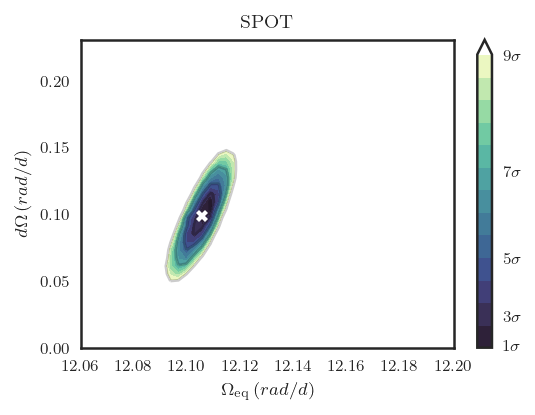

In [62]:
fig, ax = P.subplots(1,1, figsize=(4,3), sharey=True)
cmap.set_over('white')
#ax.scatter(Oeq, dO, marker = 's', s=20, color='gray', alpha=0.8)
ax.set_title('SPOT')
im = ax.contourf(x, y, z, levels=N.linspace(lev[0], lev[-1], 14,endpoint=True), cmap=cmap, alpha=1., extend='max')
ax.contour(x, y, z, levels=lev_1, colors='k', alpha=0.2)
# Add colorbar
cbar = fig.colorbar(im, ticks=lev_1, ticklocation = 'right', format = '%1.4f')
cbar.ax.set_yticklabels([r'$ %1d \sigma$' %isig for isig in range(1,cut_sigma,2)])
ax.set_xlim(lev_o); ax.set_ylim(lev_do)
ax.plot(best_x, best_y, 'X', color='w')
ax.set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$')
ax.set_ylabel(r'$d\Omega \left(rad/d\right)$')
P.tight_layout()
P.savefig('figs/dr_i_2004.png')

In [63]:
# load modules
import numpy as N
import matplotlib.pyplot as P
from scipy.optimize import leastsq
import cmocean as cm

#Define the number of sigmas that you want to consider 
nsigma=9.

# Read file with informations in each run
beta_v, gamma_v, chisq_v, s_v, bmod, test_v = N.genfromtxt('data/search_dr_v_2004.txt', unpack=True)

#Change to oeq and do
period =  0.5211833875 # in days
Omega0 = 2*N.pi/period
print(Omega0)
Oeq_v = (1 - beta_v)*Omega0
dO_v = gamma_v*Omega0

# Now we need to find the number of points to find the error bar
cycle, vr, snI, I, cycleV, vrV, snV, V = rstokes('data/v471tau_04.ss')
count=0
for i in range(len(cycle)):
    count += I[i].shape[0]
    
#Compute the corresponding variation in "reduced chisq"
dchisq_v = nsigma**2*2.3/count

# Set global min of spot coverage
vmin_v = bmod.min()
bmod /= vmin_v
print(vmin_v)


#Set levels for plotting
lev_v = [1 + isigma**2*(2.3/count) for isigma in range(int(nsigma)+1)]
cut_sigma = int(nsigma) + 2
lev_1_v = [1 + isigma**2*(2.3/count) for isigma in range(1,cut_sigma,2)]

#select data within the conditions:
isp = N.bitwise_and(chisq_v <= 1.0205, test_v <= 0.005)
Oeq_v = Oeq_v[isp]; dO_v = dO_v[isp]; chisq_v = chisq_v[isp]; s_v = s_v[isp]; bmod = bmod[isp] 
test_v = test_v[isp]

#we also add another condition for the data (optional):
ic_v = N.bitwise_and(bmod >= 1., bmod <= (1. + cut_sigma**2*3.53/count))
Oeq_v = Oeq_v[ic_v]; dO_v = dO_v[ic_v]; chisq_v = chisq_v[ic_v]; s_v = s_v[ic_v]; bmod = bmod[ic_v] 
test_v = test_v[ic_v]

# Create a mesh and create new matrix with mesh's shape
x_v, y_v = N.meshgrid(N.unique(Oeq_v), N.unique(dO_v))
m_z_v = N.ones_like(x_v)*9999.
m_test_v = N.ones_like(x_v)*9999.
for i in range(chisq_v.shape[0]):
    indx = N.bitwise_and(x_v == Oeq_v[i], y_v == dO_v[i])
    m_z_v[indx] = chisq_v[i]
    m_test_v[indx] = test_v[i]
mask_v = m_z_v > (vmin_v + cut_sigma**2*3.53/count)
z_v=N.ma.array(m_z_v, mask=mask_v)  
mask1_v = m_test_v >= 1.
c_test_v=N.ma.array(m_test_v, mask=mask1_v) 

#test interpolation, method 2
import matplotlib.tri as tri
# Perform linear interpolation of the data (x,y)
# on a grid defined by (xi,yi)
triang = tri.Triangulation(Oeq_v, dO_v)
interpolator = tri.LinearTriInterpolator(triang, bmod)
z_v = interpolator(x_v, y_v)
interpolator_test = tri.LinearTriInterpolator(triang, test_v)
c_test_v = interpolator_test(x_v, y_v)


print(' Number of points in the fit: ', Oeq_v.shape[0])
print('\n The lowest Chi2 in the data was at:')
print('Oeq = ', Oeq_v[chisq_v.argmin()], 'dO = ', dO_v[chisq_v.argmin()])

# find center in the 2d-plane
optimize_func = lambda x: x[0]*Oeq_v**2 + x[1]*Oeq_v + x[2]*dO_v**2 + x[3]*dO_v \
                            + x[4]*Oeq_v*dO_v + x[5] - bmod
coef = leastsq(optimize_func, [1.,1.,1.,1.,1.,1.])[0]
a, b, c, d, e, f = coef.copy()
best_x = 1./(4*a*c/e - e)*(d - 2.*c*b/e)
best_y = 1./(4*a*c/e - e)*(b - 2.*a*d/e)
dx = 1./N.sqrt(a - e**2/(4*c))
dy = 1./N.sqrt(c - e**2/(4*a))

dx /= N.sqrt(count)
dy /= N.sqrt(count)

w_min_v = a*best_x**2 + b*best_x + c*best_y**2 + d*best_y + e*best_x*best_y + f 
res_v = a*Oeq_v**2 + b*Oeq_v + c*dO_v**2 + d*dO_v + e*Oeq_v*dO_v + f - bmod


print('Position of the center on this plane:')
print(r'Omega_EQ = %.3f and dO = %.3f' %(best_x, best_y))
print('dOeq = %.3f and d(dO) = %1.3f' %(dx, dy))

print(r'beta = %.5f and gamma = %.5f' %(1.- best_x/Omega0, best_y/Omega0))


print('\n Min chisq from fit:')
print('Min chisq = ', w_min_v)
print('RMS = ', N.sqrt(N.mean(res_v**2)))
print('RMS x dchisq =', N.sqrt(N.mean(res_v**2))*(count/2.3)) #2params

12.055613163954858
148.99
 Number of points in the fit:  400

 The lowest Chi2 in the data was at:
Oeq =  12.100000002726434 dO =  0.07299999272330093
Position of the center on this plane:
Omega_EQ = 12.112 and dO = 0.110
dOeq = 0.001 and d(dO) = 0.002
beta = -0.00467 and gamma = 0.00908

 Min chisq from fit:
Min chisq =  1.0004389980749693
RMS =  0.0003775914811522299
RMS x dchisq = 4.563603475247691


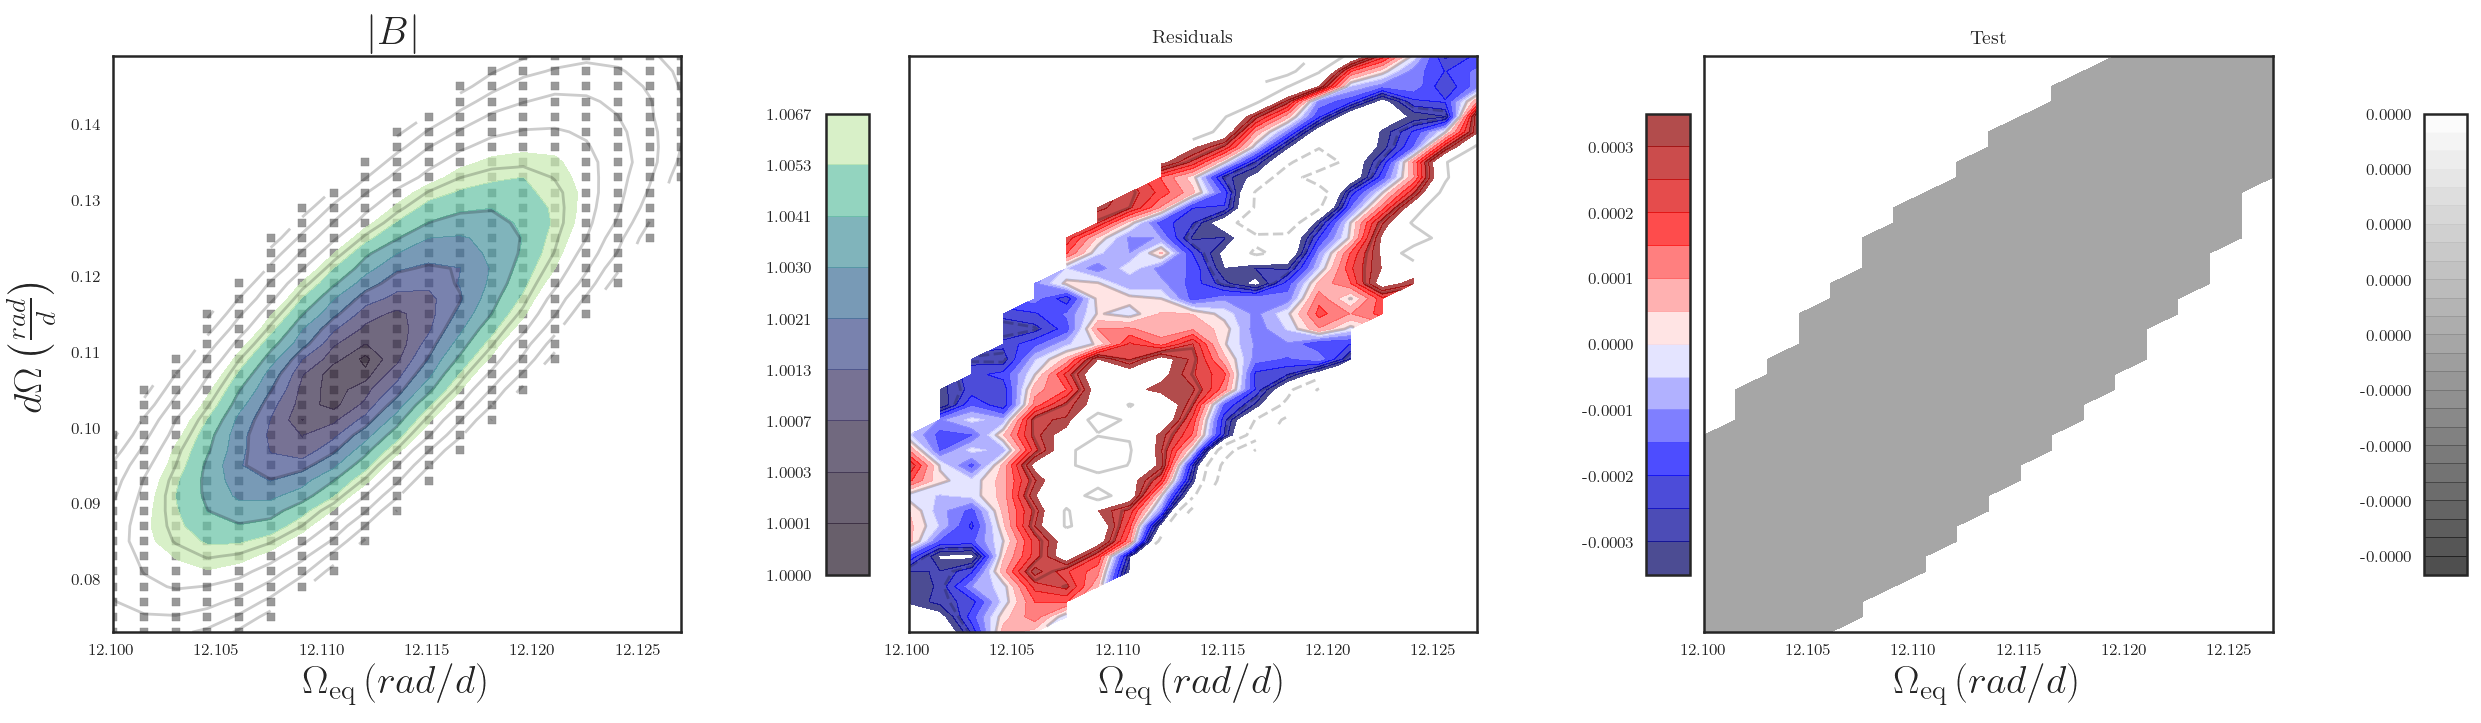

In [64]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
cmap = cmocean.cm.deep_r 

fig, ax = P.subplots(1,3, figsize=(15,4), sharey=True)
ax[0].scatter(Oeq_v, dO_v, marker = 's', s=20, color='gray', alpha=0.8)
#ax[0].scatter(x_v, y_v, c=z_v, marker = 's', s=20, alpha=1.)
ax[0].set_title(r'$|B|$', fontsize=20)
im = ax[0].contourf(x_v, y_v, z_v, levels=lev_v, cmap=cmap, alpha=0.7)
ax[0].contour(x_v, y_v, z_v, colors='k', alpha=0.2)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax = fig.add_axes([0.33, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im, cax = cax, ticklocation = 'left', format = '%.4f')
cbar.ax.set_xticklabels([r'%d \sigma' %i for i in range(0,int(nsigma)+1)])
ax[0].set_xlim((x_v.min(), x_v.max()))
ax[0].set_ylim((y_v.min(), y_v.max()))
ax[0].plot(best_x, best_y, 'x', color='k')
ax[0].set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$', fontsize=20)
ax[0].set_ylabel(r'$d\Omega \left(\frac{rad}{d}\right)$', fontsize=20)

# Residual
res_v = a*x_v**2 + b*x_v + c*y_v**2 + d*y_v + e*x_v*y_v + f - z_v
ax[1].set_title('Residuals')
im1 = ax[1].contourf(x_v, y_v, res_v, levels=N.linspace(-1,1,15)*4.e-4, cmap='seismic', alpha=0.7)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax1 = fig.add_axes([0.71, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im1, cax = cax1, ticklocation = 'left', format = '%.4f')
ax[1].contour(x_v, y_v, res_v, colors='k', alpha=0.2)
ax[1].set_xlim((x_v.min(), x_v.max()))
ax[1].set_ylim((y_v.min(), y_v.max()))
ax[1].plot(best_x, best_y, 'x', color='k')
ax[1].set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$', fontsize=20)

# Test
ax[2].set_title('Test')
im2 = ax[2].contourf(x_v, y_v, c_test_v, 30, cmap='gray', alpha=0.7)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax2 = fig.add_axes([1.07, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im2, cax = cax2, ticklocation = 'left', format = '%.4f')
ax[2].set_xlim((x_v.min(), x_v.max()))
ax[2].set_ylim((y_v.min(), y_v.max()))
ax[2].plot(best_x, best_y, 'x', color='k')
ax[2].set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$', fontsize=20)
fig.subplots_adjust(left = .0, right = 1., top = 1., bottom = .0, wspace = .4, hspace = .1)
#P.tight_layout()

P.show()

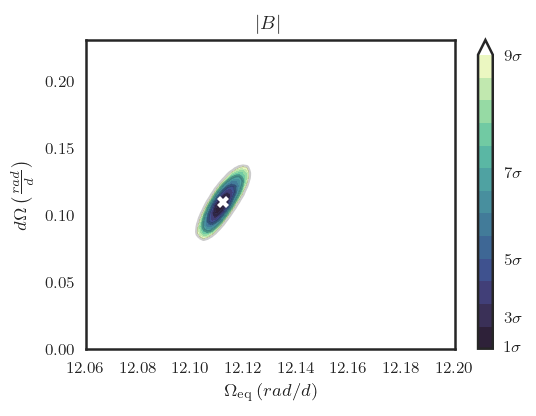

In [65]:
fig, ax = P.subplots(1,1, figsize=(4,3), sharey=True)
cmap.set_over('white')
#ax.scatter(Oeq_v, dO_v, marker = 's', s=20, color='gray', alpha=0.8)
ax.set_title(r'$|B|$')
im = ax.contourf(x_v, y_v, z_v, levels=N.linspace(lev_v[0], lev_v[-1], 14), cmap=cmap, alpha=1., extend='max')
ax.contour(x_v, y_v, z_v, levels=lev_1_v, colors='k', alpha=0.2)
cbar = fig.colorbar(im, ticks=lev_1_v, ticklocation = 'right', format = '%1.4f')
cbar.ax.set_yticklabels([r'$ %1d \sigma$' %isig for isig in range(1,cut_sigma,2)])
ax.set_xlim(lev_o)
ax.set_ylim(lev_do)
ax.plot(best_x, best_y, 'X', color='w')
ax.set_ylabel(r'$d\Omega \left(\frac{rad}{d}\right)$')
ax.set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$')
P.tight_layout()
P.savefig('figs/dr_v_2004.png')

### DATA IN 2005  

In [66]:
# load modules
import numpy as N
import matplotlib.pyplot as P
from scipy.optimize import leastsq
import cmocean as cm
import matplotlib.font_manager

#Define the number of sigmas that you want to consider 
nsigma=9.

# Read file with informations in each run
beta, gamma, chisq, s, sp_ph, test, cool, hot = N.genfromtxt('data/search_dr_i_2005.txt', unpack=True)

#Change to oeq and do
period =  0.5211833875 # in days
Omega0 = 2*N.pi/period
print(Omega0)
Oeq = (1 - beta)*Omega0
dO = gamma*Omega0

# Now we need to find the number of points to find the error bar
cycle, vr, snI, I, cycleV, vrV, snV, V = rstokes('data/v471tau_05.ss')
count=0
for i in range(len(cycle)):
    count += I[i].shape[0]
    
#Compute the corresponding variation in "reduced chisq"
dchisq = nsigma**2*2.3/count

# Set global min of spot coverage
vmin = sp_ph.min()
sp_ph /= vmin

#Set levels for plotting
lev = [1. + isigma**2*(2.3/count) for isigma in range(int(nsigma)+1)]
cut_sigma = int(nsigma) + 2
lev_1 = [1. + isigma**2*(2.3/count) for isigma in range(1,cut_sigma,2)]

#select data within the conditions:
ic = N.bitwise_and(chisq <= 1.0005, test <= 0.005)
Oeq = Oeq[ic]; dO = dO[ic]; chisq = chisq[ic]; s = s[ic]; sp_ph = sp_ph[ic] 
test = test[ic]; cool = cool[ic]; hot = hot[ic]
#we also add another condition for the data (optional):
isp = N.bitwise_and(sp_ph >= 1.00*vmin, sp_ph <= (1. + cut_sigma**2*3.53/count))
Oeq = Oeq[isp]; dO = dO[isp]; chisq = chisq[isp]; s = s[isp]; sp_ph = sp_ph[isp] 
test = test[isp]; cool = cool[isp]; hot = hot[isp]

# Create a mesh and create new matrix with mesh's shape
x, y = N.meshgrid(N.unique(Oeq), N.unique(dO))
m_z = N.ones_like(x)*9999.
m_test = N.ones_like(x)*9999.

for i in range(sp_ph.shape[0]):
    indx = N.bitwise_and(x == Oeq[i], y == dO[i])
    m_z[indx] = sp_ph[i]
    m_test[indx] = test[i]

mask = m_z > (1.+cut_sigma**2*3.53/count)
z=N.ma.array(m_z, mask=mask)  
mask1 = m_test >= 1.
c_test=N.ma.array(m_test, mask=mask1)  

print(' Number of points in the fit: ', Oeq.shape[0])
print('\n The lowest spot in the data was at:')
print('Oeq = ', Oeq[sp_ph.argmin()], 'dO = ', dO[sp_ph.argmin()],'\n')

# find center in the 2d-plane
optimize_func = lambda x: x[0]*Oeq**2 + x[1]*Oeq + x[2]*dO**2 + x[3]*dO \
                            + x[4]*Oeq*dO + x[5] - sp_ph
coef = leastsq(optimize_func, [1.,1.,1.,1.,1.,1.])[0]
a, b, c, d, e, f = coef.copy()
best_x = 1./(4*a*c/e - e)*(d - 2.*c*b/e)
best_y = 1./(4*a*c/e - e)*(b - 2.*a*d/e)
dx = 1./N.sqrt(a - e**2/(4*c))
dy = 1./N.sqrt(c - e**2/(4*a))

dx /= N.sqrt(count)
dy /= N.sqrt(count)

w_min = a*best_x**2 + b*best_x + c*best_y**2 + d*best_y + e*best_x*best_y + f 
res = a*Oeq**2 + b*Oeq + c*dO**2 + d*dO + e*Oeq*dO + f - sp_ph


print('Position of the center on this plane:')
print(r'Omega_EQ = %.3f and dO = %.3f' %(best_x, best_y))
print('dOeq = %.3f and d(dO) = %1.3f' %(dx, dy))

print(r'beta = %.6f and gamma = %.6f' %(1.- best_x/Omega0, best_y/Omega0))


print('\n Min Spot from fit:')
print('Min Spot = ', w_min)
print('RMS = ', N.sqrt(N.mean(res**2)))
print('RMS x dchisq =', N.sqrt(N.mean(res**2))*(count/2.3)) #2params

12.055613163954858
 Number of points in the fit:  224

 The lowest spot in the data was at:
Oeq =  12.091499951552924 dO =  0.07700004517110115 

Position of the center on this plane:
Omega_EQ = 12.093 and dO = 0.079
dOeq = 0.001 and d(dO) = 0.003
beta = -0.003084 and gamma = 0.006590

 Min Spot from fit:
Min Spot =  1.0001618678161321
RMS =  0.0007975449306561571
RMS x dchisq = 16.980771849666095


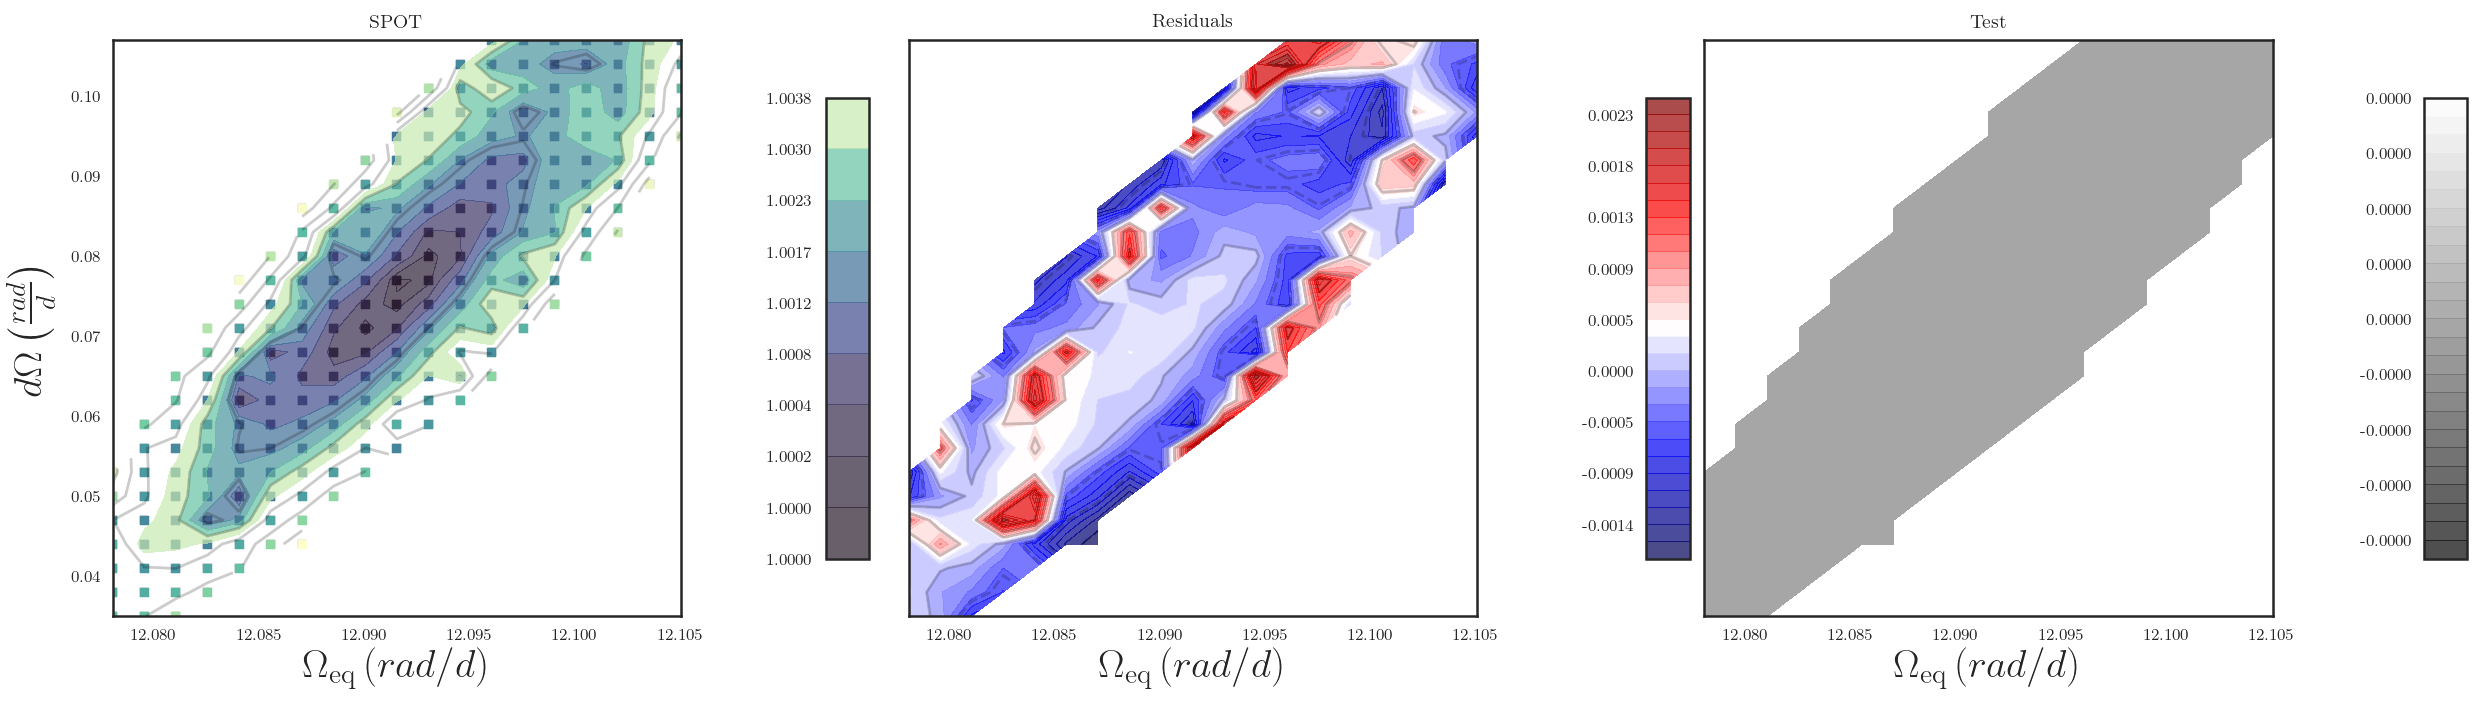

In [67]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = P.subplots(1,3, figsize=(15,4), sharey=True)
ax[0].scatter(Oeq, dO, marker = 's', s=20, color='gray', alpha=0.8)
ax[0].scatter(x, y, c=z, cmap=cmap, marker = 's', s=20, alpha=1.)
ax[0].set_title('SPOT')
im = ax[0].contourf(x, y, z, levels=lev, cmap=cmap, alpha=0.7)
ax[0].contour(x, y, z, colors='k', alpha=0.2)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax = fig.add_axes([0.33, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im, cax = cax, ticklocation = 'left', format = '%1.4f')
#cbar.ax.set_yticklabels([r'$%d \sigma$' %i for i in range(1,int(nsigma)+1)])
ax[0].set_xlim((x.min(), x.max()))
ax[0].set_ylim((y.min(), y.max()))
ax[0].plot(best_x, best_y, 'x', color='k')
ax[0].set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$', fontsize=20)
ax[0].set_ylabel(r'$d\Omega \left(\frac{rad}{d}\right)$', fontsize=20)

# Residual
res = a*x**2 + b*x + c*y**2 + d*y + e*x*y + f - z
ax[1].set_title('Residuals')
im1 = ax[1].contourf(x, y, res, 30, cmap='seismic', alpha=0.7)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax1 = fig.add_axes([0.71, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im1, cax = cax1, ticklocation = 'left', format = '%1.4f')
ax[1].contour(x, y, res, colors='k', alpha=0.2)
ax[1].set_xlim((x.min(), x.max()))
ax[1].set_ylim((y.min(), y.max()))
ax[1].plot(best_x, best_y, 'x', color='k')
ax[1].set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$', fontsize=20)

# Test
ax[2].set_title('Test')
im2 = ax[2].contourf(x, y, c_test, 30, cmap='gray', alpha=0.7)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax2 = fig.add_axes([1.07, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im2, cax = cax2, ticklocation = 'left', format = '%1.4f')
ax[2].set_xlim((x.min(), x.max()))
ax[2].set_ylim((y.min(), y.max()))
ax[2].plot(best_x, best_y, 'x', color='k')
ax[2].set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$', fontsize=20)
fig.subplots_adjust(left = .0, right = 1., top = 1., bottom = .0, wspace = .4, hspace = .1)
#P.tight_layout()
P.show()

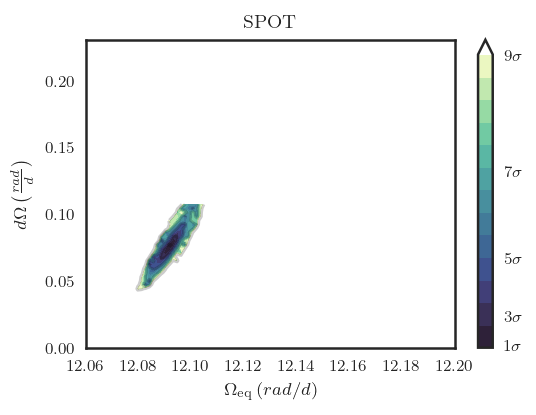

In [68]:
fig, ax = P.subplots(1,1, figsize=(4,3), sharey=True)
cmap.set_over('white')
#ax.scatter(Oeq, dO, marker = 's', s=20, color='gray', alpha=0.8)
ax.set_title(r'SPOT')
im = ax.contourf(x, y, z, levels=N.linspace(lev[0], lev[-1], 14), cmap=cmap, alpha=1., extend='max')
ax.contour(x, y, z, levels=lev_1, colors='k', alpha=0.2)
cbar = fig.colorbar(im, ticks=lev_1, ticklocation = 'right', format = '%1.4f')
cbar.ax.set_yticklabels([r'$ %1d \sigma$' %isig for isig in range(1,cut_sigma,2)])
ax.set_xlim(lev_o)
ax.set_ylim(lev_do)
ax.plot(best_x, best_y, 'x', color='w')
ax.set_ylabel(r'$d\Omega \left(\frac{rad}{d}\right)$')
ax.set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$')
P.tight_layout()
P.savefig('figs/dr_i_chipot_2004.png')

In [69]:
# load modules
import numpy as N
import matplotlib.pyplot as P
from scipy.optimize import leastsq
import cmocean as cm
#Define the number of sigmas that you want to consider 
nsigma=9.

# Read file with informations in each run
beta_v, gamma_v, chisq_v, s_v, bmod, test_v = N.genfromtxt('data/search_dr_v_2005.txt', unpack=True)

#Change to oeq and do
period =  0.5211833875 # in days
Omega0 = 2*N.pi/period
print(Omega0)
Oeq_v = (1 - beta_v)*Omega0
dO_v = gamma_v*Omega0

# Now we need to find the number of points to find the error bar
cycle, vr, snI, I, cycleV, vrV, snV, V = rstokes('data/v471tau_05.ss')
count=0
for i in range(len(cycle)):
    count += I[i].shape[0]
    
#Compute the corresponding variation in "reduced chisq"
dchisq_v = nsigma**2*2.3/count

# Set global min of spot coverage
vmin_v = bmod.min()
bmod /= vmin_v
print(vmin_v)


#Set levels for plotting
lev_v = [1 + isigma**2*(2.3/count) for isigma in range(int(nsigma)+1)]
cut_sigma = int(nsigma) + 2
lev_1_v = [1 + isigma**2*(2.3/count) for isigma in range(1,cut_sigma,2)]

#select data within the conditions:
isp = N.bitwise_and(chisq_v <= 1.0755, test_v <= 0.005)
Oeq_v = Oeq_v[isp]; dO_v = dO_v[isp]; chisq_v = chisq_v[isp]; s_v = s_v[isp]; bmod = bmod[isp] 
test_v = test_v[isp]

#we also add another condition for the data (optional):
ic_v = N.bitwise_and(bmod >= 1., bmod <= (1. + cut_sigma**2*3.53/count))
Oeq_v = Oeq_v[ic_v]; dO_v = dO_v[ic_v]; chisq_v = chisq_v[ic_v]; s_v = s_v[ic_v]; bmod = bmod[ic_v] 
test_v = test_v[ic_v]

# Create a mesh and create new matrix with mesh's shape
x_v, y_v = N.meshgrid(N.unique(Oeq_v), N.unique(dO_v))
m_z_v = N.ones_like(x_v)*9999.
m_test_v = N.ones_like(x_v)*9999.
for i in range(chisq_v.shape[0]):
    indx = N.bitwise_and(x_v == Oeq_v[i], y_v == dO_v[i])
    m_z_v[indx] = chisq_v[i]
    m_test_v[indx] = test_v[i]
mask_v = m_z_v > (vmin_v + cut_sigma**2*3.53/count)
z_v=N.ma.array(m_z_v, mask=mask_v)  
mask1_v = m_test_v >= 1.
c_test_v=N.ma.array(m_test_v, mask=mask1_v) 

#test interpolation, method 2
import matplotlib.tri as tri
# Perform linear interpolation of the data (x,y)
# on a grid defined by (xi,yi)
triang = tri.Triangulation(Oeq_v, dO_v)
interpolator = tri.LinearTriInterpolator(triang, bmod)
z_v = interpolator(x_v, y_v)
interpolator_test = tri.LinearTriInterpolator(triang, test_v)
c_test_v = interpolator_test(x_v, y_v)


print(' Number of points in the fit: ', Oeq_v.shape[0])
print('\n The lowest Chi2 in the data was at:')
print('Oeq = ', Oeq_v[chisq_v.argmin()], 'dO = ', dO_v[chisq_v.argmin()],'\n')

# find center in the 2d-plane
optimize_func = lambda x: x[0]*Oeq_v**2 + x[1]*Oeq_v + x[2]*dO_v**2 + x[3]*dO_v \
                            + x[4]*Oeq_v*dO_v + x[5] - bmod
coef = leastsq(optimize_func, [1.,1.,1.,1.,1.,1.])[0]
a, b, c, d, e, f = coef.copy()
best_x = 1./(4*a*c/e - e)*(d - 2.*c*b/e)
best_y = 1./(4*a*c/e - e)*(b - 2.*a*d/e)
dx = 1./N.sqrt(a - e**2/(4*c))
dy = 1./N.sqrt(c - e**2/(4*a))

dx /= N.sqrt(count)
dy /= N.sqrt(count)

w_min_v = a*best_x**2 + b*best_x + c*best_y**2 + d*best_y + e*best_x*best_y + f 
res_v = a*Oeq_v**2 + b*Oeq_v + c*dO_v**2 + d*dO_v + e*Oeq_v*dO_v + f - bmod


print('Position of the center on this plane:')
print(r'Omega_EQ = %.3f and dO = %.3f' %(best_x, best_y))
print('dOeq = %.4f and d(dO) = %1.3f' %(dx, dy))

print(r'beta = %.5f and gamma = %.6f' %(1.- best_x/Omega0, best_y/Omega0))


print('\n Min chisq from fit:')
print('Min chisq = ', w_min_v)
print('RMS = ', N.sqrt(N.mean(res_v**2)))
print('RMS x dchisq =', N.sqrt(N.mean(res_v**2))*(count/2.3)) #2params

12.055613163954858
192.08
 Number of points in the fit:  163

 The lowest Chi2 in the data was at:
Oeq =  12.079999981599697 dO =  0.030000031690106746 

Position of the center on this plane:
Omega_EQ = 12.089 and dO = 0.058
dOeq = 0.0005 and d(dO) = 0.001
beta = -0.00276 and gamma = 0.004780

 Min chisq from fit:
Min chisq =  0.9999254069261951
RMS =  0.00010506383932942335
RMS x dchisq = 2.236946179113853


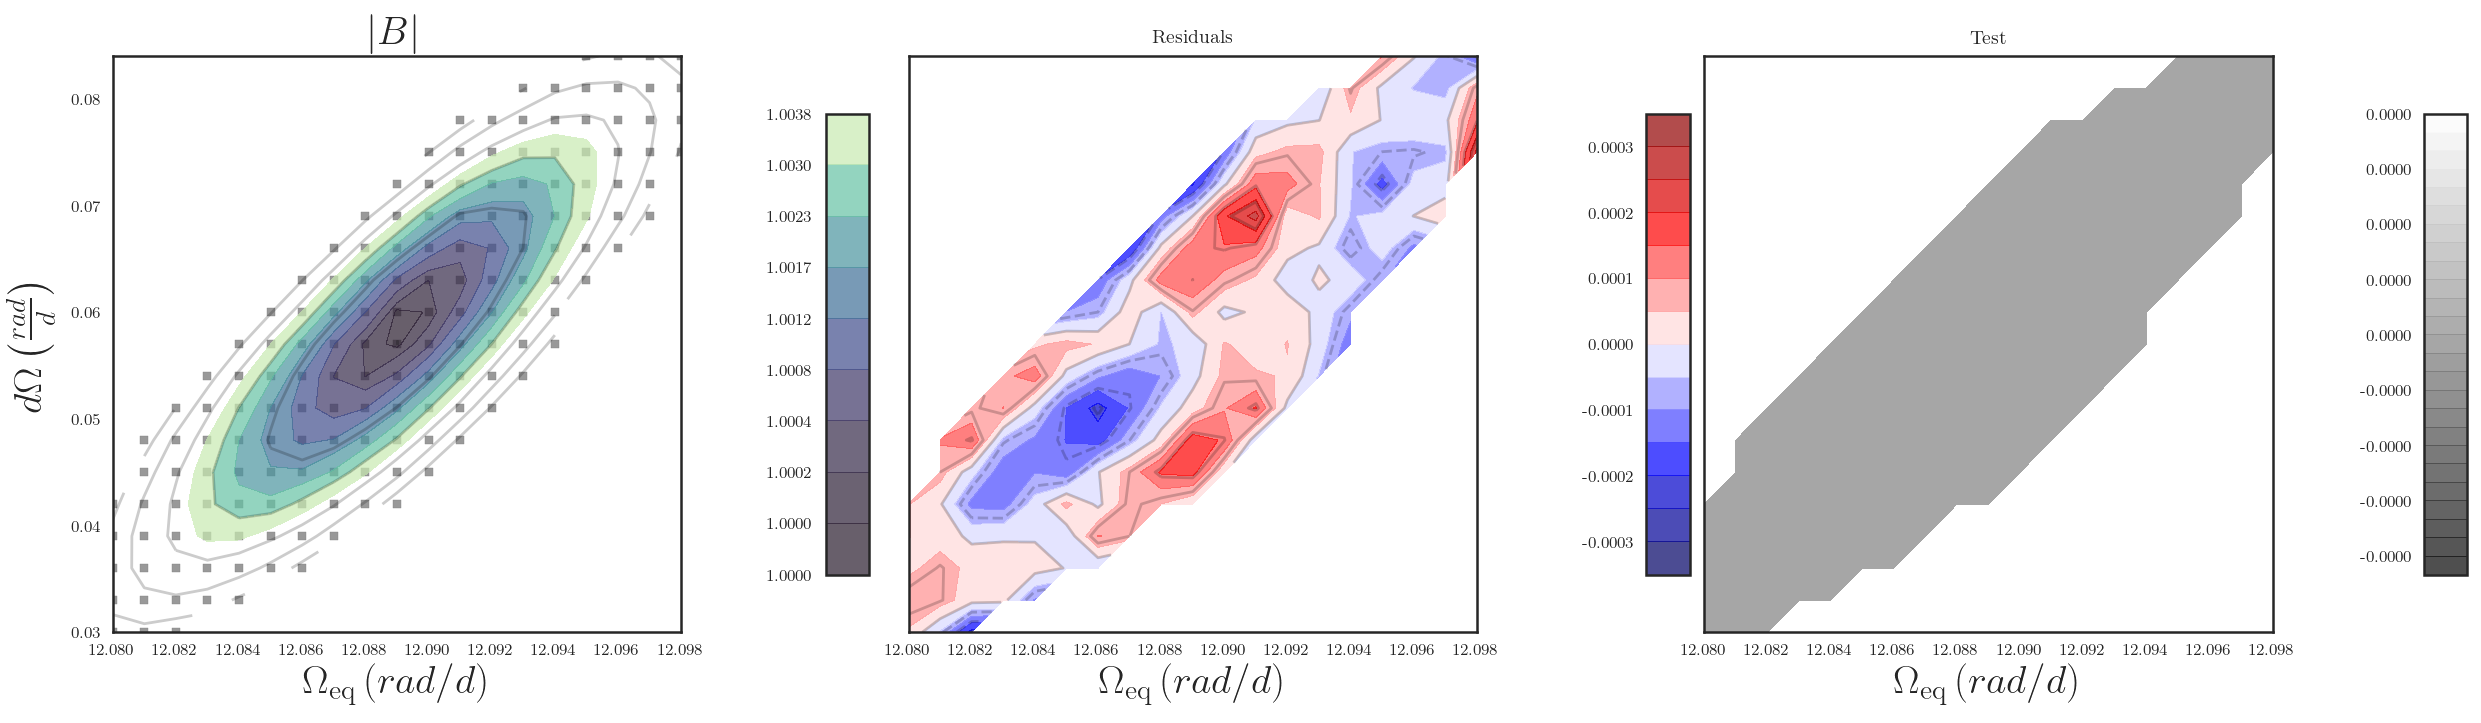

In [70]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
cmap = cmocean.cm.deep_r 

fig, ax = P.subplots(1,3, figsize=(15,4), sharey=True)
ax[0].scatter(Oeq_v, dO_v, marker = 's', s=20, color='gray', alpha=0.8)
#ax[0].scatter(x_v, y_v, c=z_v, marker = 's', s=20, alpha=1.)
ax[0].set_title(r'$|B|$', fontsize=20)
im = ax[0].contourf(x_v, y_v, z_v, levels=lev_v, cmap=cmap, alpha=0.7)
ax[0].contour(x_v, y_v, z_v, colors='k', alpha=0.2)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax = fig.add_axes([0.33, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im, cax = cax, ticklocation = 'left', format = '%.4f')
cbar.ax.set_xticklabels([r'%d \sigma' %i for i in range(0,int(nsigma)+1)])
ax[0].set_xlim((x_v.min(), x_v.max()))
ax[0].set_ylim((y_v.min(), y_v.max()))
ax[0].plot(best_x, best_y, 'x', color='k')
ax[0].set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$', fontsize=20)
ax[0].set_ylabel(r'$d\Omega \left(\frac{rad}{d}\right)$', fontsize=20)

# Residual
res_v = a*x_v**2 + b*x_v + c*y_v**2 + d*y_v + e*x_v*y_v + f - z_v
ax[1].set_title('Residuals')
im1 = ax[1].contourf(x_v, y_v, res_v, levels=N.linspace(-1,1,15)*4.e-4, cmap='seismic', alpha=0.7)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax1 = fig.add_axes([0.71, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im1, cax = cax1, ticklocation = 'left', format = '%.4f')
ax[1].contour(x_v, y_v, res_v, colors='k', alpha=0.2)
ax[1].set_xlim((x_v.min(), x_v.max()))
ax[1].set_ylim((y_v.min(), y_v.max()))
ax[1].plot(best_x, best_y, 'x', color='k')
ax[1].set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$', fontsize=20)

# Test
ax[2].set_title('Test')
im2 = ax[2].contourf(x_v, y_v, c_test_v, 30, cmap='gray', alpha=0.7)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax2 = fig.add_axes([1.07, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im2, cax = cax2, ticklocation = 'left', format = '%.4f')
ax[2].set_xlim((x_v.min(), x_v.max()))
ax[2].set_ylim((y_v.min(), y_v.max()))
ax[2].plot(best_x, best_y, 'x', color='k')
ax[2].set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$', fontsize=20)
fig.subplots_adjust(left = .0, right = 1., top = 1., bottom = .0, wspace = .4, hspace = .1)
#P.tight_layout()

P.show()

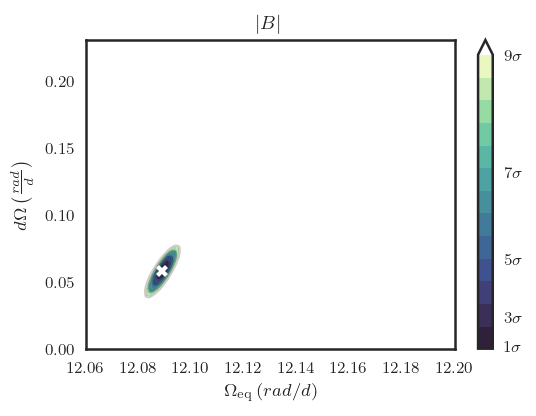

In [71]:
fig, ax = P.subplots(1,1, figsize=(4,3), sharey=True)
cmap.set_over('white')
#ax.scatter(Oeq_v, dO_v, marker = 's', s=20, color='gray', alpha=0.8)
ax.set_title(r'$|B|$')
im = ax.contourf(x_v, y_v, z_v, levels=N.linspace(lev_v[0], lev_v[-1], 14), cmap=cmap, alpha=1., extend='max')
ax.contour(x_v, y_v, z_v, levels=lev_1_v, colors='k', alpha=0.2)
cbar = fig.colorbar(im, ticks=lev_1_v, ticklocation = 'right', format = '%1.4f')
cbar.ax.set_yticklabels([r'$ %1d \sigma$' %isig for isig in range(1,cut_sigma,2)])
ax.set_xlim(lev_o)
ax.set_ylim(lev_do)
ax.plot(best_x, best_y, 'X', color='w')
ax.set_ylabel(r'$d\Omega \left(\frac{rad}{d}\right)$')
ax.set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$')
P.tight_layout()
P.savefig('figs/dr_v_2004.png')

-----------

# Fluctuations in DR

In [72]:
period =  0.521183398 # in days
Omega0 = 2*N.pi/period

Oeq04 = 12.104; dO04 = 0.093
dOeq04 = 0.001; ddO04 = 0.004

Oeq04V = 12.114; dO04V = 0.113
dOeq04V = 0.001; ddO04V = 0.002


Oeq05 = 12.094; dO05 = 0.081
dOeq05 = 0.001; ddO05 = 0.003
scale=1000


Oeq05V = 12.088; dO05V = 0.056
dOeq05V = 0.0005; ddO05V = 0.001

scale=1e3

fits = N.poly1d(N.polyfit(N.array([0, dO04, dO04V, dO05, dO05V])*scale, [Omega0, Oeq04, Oeq04V, Oeq05, Oeq05V], deg = 1))


In [73]:
print(fits)
print(fits[1]*scale)

 
0.0005064 x + 12.06
0.5063747315985594


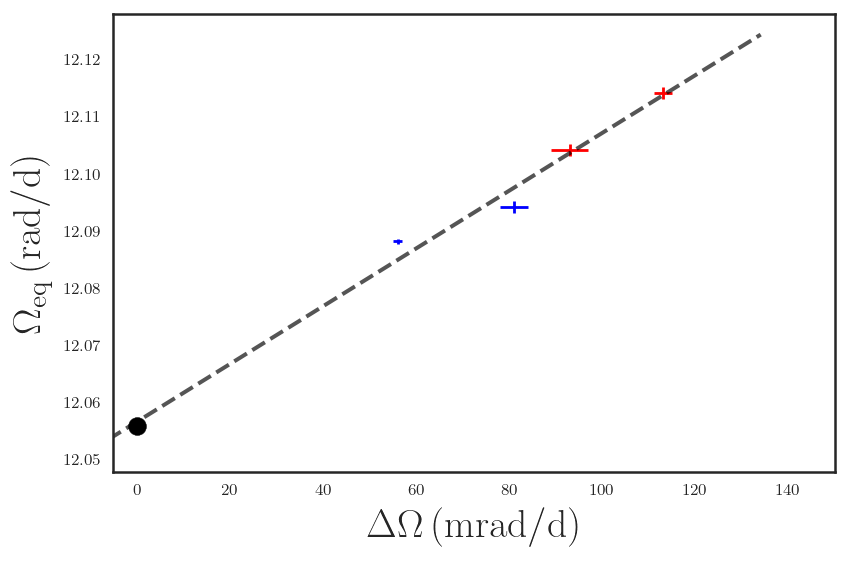

In [74]:
P.errorbar(scale*dO04, Oeq04,  yerr=dOeq04, xerr=scale*ddO04, color='r')
P.errorbar(scale*dO04V, Oeq04V, yerr=dOeq04V, xerr=scale*ddO04V,color='r')
P.errorbar(scale*dO05, Oeq05, yerr=dOeq05, xerr=scale*ddO05,color='b')
P.errorbar(scale*dO05V, Oeq05V,  yerr=dOeq05V, xerr=scale*ddO05V,color='b')
P.scatter(0,Omega0, s=80,marker='o', color='k')
xrange = range(-10,140,8)
P.plot(xrange, fits(xrange), '--k', linewidth=2, alpha=0.666)
P.xlabel(r'$\Delta\Omega \left(\mathrm{mrad/d}\right)$', fontsize=20)
P.ylabel(r'$\Omega_\mathrm{eq} \left(\mathrm{rad/d}\right)$', fontsize=20)
P.xlim((-5,150))
P.tight_layout()
P.savefig('figs/diff_rot-spot.png', dpi=100, transparent=True)